In [31]:
# Install needed libraries
#!pip install pandas biopython requests scipy plotnine

In [1]:
import pandas as pd
from Bio import Entrez
from Bio import SeqIO
from Bio.Seq import Seq
import requests
import pickle
from scipy.stats import chisquare

In [2]:
# Create sets of codons encoding amino acids 

alanine       = {"GCT", "GCC", "GCA", "GCG"}
arginine      = {"CGT", "CGC", "CGA", "CGG", "AGA", "AGG"}
asparagine    = {"AAT", "AAC"}
aspartic_acid = {"GAT", "GAC"}
cysteine      = {"TGT", "TGC"}
glutamine     = {"CAT", "CAG"}
glutamic_acid = {"GAA", "GAG"}
glycine       = {"GGT", "GGC", "GGA", "GGG"}
histidine     = {"CAT", "CAC"}
isoleucine    = {"ATT", "ATC", "ATA"}
leucine       = {'CTG', 'CTA', 'CTT', 'CTC', 'TTA', 'TTG'}
lysine        = {"AAA", "AAG"}
methionine    = {"ATG"}
phenylalanine = {"TTT", "TTC"}
proline       = {"CCT", "CCC", "CCA", "CCG"}
serine        = {"TCT", "TCC", "TCA", "TCG", "AGT", "AGC"}
threonine     = {"ACT", "ACC", "ACA", "ACG"}
tryptophan    = {"TGG"}
tyrosine      = {"TAT", "TAC"}
valine        = {"GTT", "GTC", "GTA", "GTG"}
stop_codons   = {"TAA", "TAG", "TGA"}

amino_acids = {
    "A": alanine,
    "R": arginine,
    "N": asparagine,
    "D": aspartic_acid,
    "C": cysteine,
    "Q": glutamine,
    "E": glutamic_acid,
    "G": glycine,
    "H": histidine,
    "I": isoleucine,
    "L": leucine,
    "K": lysine,
    "M": methionine,
    "F": phenylalanine,
    "P": proline,
    "S": serine,
    "T": threonine,
    "W": tryptophan,
    "Y": tyrosine,
    "V": valine,
    "*": stop_codons
}

codon_to_amino_acid = {codon: aa for aa, codon_set in amino_acids.items() for codon in codon_set}

In [3]:
"""
    Download Catalytic sites Atlas data, filter columns and store them in a DataFrame
"""

url = "https://www.ebi.ac.uk/thornton-srv/m-csa/api/residues/?format=json"
data = requests.get(url).json()
df = pd.json_normalize(data)
parsed = df['residue_sequences'].apply(lambda L: L[0] if isinstance(L, list) and len(L) > 0 else {})
df = pd.DataFrame(parsed.tolist())
df.to_csv("M-CSA_API_data.csv")
df.head()

,uniprot_id,code,is_reference,resid
0,P56868,Asp,True,7
1,P56868,Cys,True,70
2,P56868,Cys,True,178
3,P56868,His,True,180
4,P56868,Ser,True,8


In [4]:
# Rename columns and filter rows only with leucine, arginine and serine
selected_columns = ["uniprot_id", "code", "resid"]
df = df[selected_columns]
df = df.rename(columns={"code": "residue", "resid": "position"})
df = df.drop_duplicates()
df = df.dropna()

interesting_AA = ["Arg", "Leu", "Ser"]
df_filtered = df[df['residue'].isin(interesting_AA)]

In [5]:
# Get unique uniprot IDs
unique_uniprot_ids = df_filtered['uniprot_id'].dropna().astype(str).unique().tolist()

# store them in a text file if needed
with open("unique_uniprot_ids.txt", "w") as f:
    f.write("\n".join(unique_uniprot_ids))

In [6]:
# Load unique uniprot IDs if needed
# with open("C:/Users\ASUS\PycharmProjects\CodonVolatilitySimulation/unique_uniprot_ids.txt", "r") as f:
#    unique_ids = set(f.read().splitlines())

# Merge residues from same protein to one line
df_merged = df_filtered.groupby("uniprot_id")[["position", "residue"]].agg(list).reset_index()
df_merged = df_merged[df_merged["uniprot_id"].isin(unique_uniprot_ids)]
df_merged.head()

,uniprot_id,position,residue
0,,"[233, 235, 351, 169, 155, 158, 131, 118, 261, ...","[Ser, Ser, Ser, Ser, Ser, Arg, Ser, Ser, Ser, ..."
1,A0A0F6FBL7,[14],[Ser]
2,A4XF23,"[147, 283]","[Arg, Arg]"
3,A5JUY8,[307],[Ser]
4,O04147,[121],[Ser]


In [7]:
def fetch_genbank_ids(uniprot_id: str) -> list[str]:
    """
    Retrieves GenBank ID corresponding to a given UniProt ID.
    """
    url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.json"
    resp = requests.get(url)
    if not resp.ok:
        print(f"Failed to fetch {uniprot_id}: HTTP {resp.status_code}")
        return []
    record = resp.json()
    xrefs = record.get("uniProtKBCrossReferences", [])
    embl_refs = [xr["id"] for xr in xrefs if xr["database"] == "EMBL"]
    return embl_refs

# Loop over your list and build a mapping dictionary
mapping = {}
for uid in unique_uniprot_ids:
    mapping[uid] = fetch_genbank_ids(uid)

# Create a dataframe
rows = []
for uid, gb_list in mapping.items():
    if gb_list:
        for gb in gb_list:
            rows.append({"uniprot_id": uid, "genBank_id": gb})
    else:
        rows.append({"uniprot_id": uid, "genBank_id": None})

uniprot_to_genbank_ids_df = pd.DataFrame(rows)
uniprot_to_genbank_ids_df.to_csv("uniprot_to_genbank.csv")
# get unique IDs of nucleotide sequences
unique_genBank_ids = uniprot_to_genbank_ids_df['genBank_id'].dropna().astype(str).unique().tolist()
uniprot_to_genbank_ids_df.head()

Failed to fetch : HTTP 404


,uniprot_id,genBank_id
0,P56868,AF212972
1,P62593,J01749
2,P62593,V00613
3,P62593,X64523
4,P62593,X57972


In [8]:
# Add GenBank ID to my dataframe
column_to_add = ["genBank_id"]
df_merged = df_merged.merge(uniprot_to_genbank_ids_df[["uniprot_id"] + column_to_add], on="uniprot_id", how="left")
df_merged = df_merged.dropna(subset=['genBank_id'])
df_merged.head()

,uniprot_id,position,residue,genBank_id
2,A4XF23,"[147, 283]","[Arg, Arg]",CP000677
3,A5JUY8,[307],[Ser],EF580919
4,A5JUY8,[307],[Ser],HQ285238
5,O04147,[121],[Ser],Y11650
6,O04147,[121],[Ser],AL021711


In [9]:
# Download Fasta files of nucleotides from NCBI
Entrez.email = "kuniaka@natur.cuni.cz"
with Entrez.efetch(db="nucleotide", id=unique_genBank_ids, rettype="fasta", retmode="text") as handle:
    seq_records = SeqIO.to_dict(SeqIO.parse(handle, "fasta"))
    seq_dict = {rec_id.split(".")[0]: str(rec.seq) for rec_id, rec in seq_records.items()}
    
df_merged['nucleotide_sequence'] = df_merged['genBank_id'].map(seq_dict)
df_merged.head()

,uniprot_id,position,residue,genBank_id,nucleotide_sequence
2,A4XF23,"[147, 283]","[Arg, Arg]",CP000677,GCTATGCAAGCGCTATCATCAGTTGCAAGACATGTCCTGAAGGGAG...
3,A5JUY8,[307],[Ser],EF580919,ATGTGGGTCTGTCTCCAACTTCCAGTCTTTTTGGCTTCCGTGACCT...
4,A5JUY8,[307],[Ser],HQ285238,AGTGTGGGAGGCTGTGGAGTCCGGGCCCCTAATTCTCCCTGGAGGC...
5,O04147,[121],[Ser],Y11650,ATTAACGTATTCCCTGATTAGTACAACTAATATAAAATGTTAATCT...
6,O04147,[121],[Ser],AL021711,TAAAACGGAGAGAGCGAGGAAAGCGAAGAAAACAAATCTTGGATGG...


In [17]:
def fetch_uniprot_record(uid: str) -> dict:
    """
    Fetches the UniProt entry for a given id and extracts its sequence data and length.
    
    Returns a dictionary with the keys "uniprot_id", "protein_sequence", "length" and "organism"
    """
    url = f"https://rest.uniprot.org/uniprotkb/{uid}.json"
    r = requests.get(url)
    r.raise_for_status()
    rec = r.json()
    seq_obj = rec.get("sequence", {})
    org_obj = rec.get("organism", {})
    return {
        "uniprot_id": uid,
        "protein_sequence": seq_obj.get("value"),
        "prot_seq_length": seq_obj.get("length"),
        "organism": org_obj.get("scientificName"),
    }

unique_uniprot_ids = [uid for uid in unique_uniprot_ids if str(uid).strip()]
records = [fetch_uniprot_record(uid) for uid in unique_uniprot_ids]
protein_df = pd.DataFrame(records)
protein_df = protein_df.dropna(subset=['protein_sequence'])
protein_df['prot_seq_length'] = protein_df['prot_seq_length'].astype(int)
protein_df.head()

,uniprot_id,protein_sequence,prot_seq_length,organism
0,P56868,MKIGIFDSGVGGLTVLKAIRNRYRKVDIVYLGDTARVPYGIRSKDT...,254,Aquifex pyrophilus
1,P62593,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,286,Escherichia coli
2,P08819,VEPSGHAADRIARLPGQPAVDFDMYSGYITVDEGAGRSLFYLLQEA...,444,Triticum aestivum
3,P9WJJ7,MGLSDWELAAARAAIARGLDEDLRYGPDVTTLATVPASATTTASLV...,285,Mycobacterium tuberculosis (strain ATCC 25618 ...
4,P31153,MNGQLNGFHEAFIEEGTFLFTSESVGEGHPDKICDQISDAVLDAHL...,395,Homo sapiens


In [18]:
# Add protein sequence from uniprot to dataframe
columns_to_add = ["protein_sequence", "prot_seq_length", "organism"]
df_merged_all = df_merged.merge(protein_df[["uniprot_id"] + columns_to_add], on="uniprot_id", how="left")
df_merged_all = df_merged_all.drop_duplicates(subset=["uniprot_id"], keep="first")
df_merged_all["residue"] = df_merged_all["residue"].apply(lambda L: [str(i) for i in L])
df_merged_all["position"] = df_merged_all["position"].apply(lambda L: [int(i) for i in L])
df_merged_all.head()

,uniprot_id,position,residue,genBank_id,nucleotide_sequence,protein_sequence,prot_seq_length,organism
0,A4XF23,"[147, 283]","[Arg, Arg]",CP000677,GCTATGCAAGCGCTATCATCAGTTGCAAGACATGTCCTGAAGGGAG...,MKITAARVIITCPGRNFVTLKIETDQGVYGIGDATLNGRELSVVAY...,402,Novosphingobium aromaticivorans (strain ATCC 7...
1,A5JUY8,[307],[Ser],EF580919,ATGTGGGTCTGTCTCCAACTTCCAGTCTTTTTGGCTTCCGTGACCT...,MWVCLQLPVFLASVTLFEVAASDTIAQAASTTTISDAVSKVKIQVN...,712,Bubalus bubalis
3,O04147,[121],[Ser],Y11650,ATTAACGTATTCCCTGATTAGTACAACTAATATAAAATGTTAATCT...,MEEVKKDVYSVWALPDEESEPRFKKLMEALRSEFTGPRFVPHVTVA...,181,Arabidopsis thaliana
9,O13297,[393],[Arg],AB008799,AAAGATCTGCTGGGAATACTATACTGATATTTCCAAAATATCCCTT...,MSYTDNPPQTKRALSLDDLVNHDENEKVKLQKLSEAANGSRPFAEN...,549,Saccharomyces cerevisiae (strain ATCC 204508 /...
14,O28603,"[265, 449]","[Arg, Ser]",AE000782,GAAAATGGTTTAATCGGAAATTGAGTAGGAGGATAAAAGTCGCATG...,MVYYPKKYELYKADEVPTEVVETDILIIGGGFSGCGAAYEAAYWAK...,643,Archaeoglobus fulgidus (strain ATCC 49558 / DS...


In [19]:
def translate(nucleotide_seq):
    """
    Pads the nucleotide sequence with trailing 'N's if needed and translates it.
    """
    nucleotide_seq = str(nucleotide_seq)
    remainder = len(nucleotide_seq) % 3
    if remainder:
        nucleotide_seq += 'N' * (3 - remainder)
    return Seq(nucleotide_seq).translate(to_stop=False)

def translate_all_frames(nucleotide_seq):
    """
    Translates the nucleotide sequence in all six reading frames (three forward and three reverse) and returns them in a list
    """
    nucleotide_seq = str(nucleotide_seq)
    # Forward frames
    forward_frames = [translate(nucleotide_seq[frame:]) for frame in range(3)]
    # Reverse complement frames
    rev_seq = str(Seq(nucleotide_seq).reverse_complement())
    reverse_frames = [translate(rev_seq[frame:]) for frame in range(3)]
    
    return forward_frames + reverse_frames

In [22]:
def align_seqs(df):
    """
    Align protein sequences to their nucleotide sequences, identify the correct reading frame,
    and extract codons at binding and non-binding positions.
    
    Returns a copy of the input with added columns:
        - "translated_sequence": the full translation in the matching frame
        - "binding_position": list of codons at the binding positions
        - "non_binding_position": list of codons for non-binding residues (R, L, S)
        - "non_binding_AA": list of the corresponding non-binding amino acids
    """
    df = df.copy()
    binding_positions = []
    non_binding_positions = []
    non_binding_AA_list = []
    
    for idx, row in df.iterrows():
        found = False
        p_length = int(row["prot_seq_length"])
        protein_sequence = str(row["protein_sequence"])
        nucleotide_sequence = str(row["nucleotide_sequence"])
        
        # Calculate forward and reverse nucleotide sequences and get all six translations.
        forward_seq = nucleotide_sequence
        rev_seq = str(Seq(nucleotide_sequence).reverse_complement())
        translations = translate_all_frames(nucleotide_sequence)
        
        for frame_idx, translated_sequence in enumerate(translations):
            translated_sequence = str(translated_sequence)

            for i, aa in enumerate(translated_sequence):
                if aa == "M" and protein_sequence == translated_sequence[i:i+p_length]:
                    offset = i
                    # Determine which nucleotide sequence to use based on the reading frame.
                    if frame_idx < 3:
                        selected_nuc_seq = forward_seq
                    else:
                        selected_nuc_seq = rev_seq
                    
                    df.loc[idx, "translated_sequence"] = translated_sequence
                    
                    # Extract binding codons from the correct nucleotide sequence.
                    binding_codons = []
                    for position in row["position"]:
                        start = frame_idx % 3 + 3 * (offset + int(position) - 1)
                        codon = selected_nuc_seq[start:start+3]
                        binding_codons.append(codon)
                    binding_positions.append(binding_codons)
                    
                    # Extract non-binding codons similarly.
                    non_binding_codons = []
                    non_binding_AA = []
                    for j, AA in enumerate(protein_sequence):
                        if AA in {"R", "L", "S"}:
                            start = frame_idx % 3 + 3 * (offset + j)
                            codon = selected_nuc_seq[start:start+3]
                            non_binding_codons.append(codon)
                            non_binding_AA.append(AA)
                    non_binding_positions.append(non_binding_codons)
                    non_binding_AA_list.append(non_binding_AA)
                    
                    found = True
                    break
            if found:
                break
        
        if not found:
            binding_positions.append([])
            non_binding_positions.append([])
            non_binding_AA_list.append([])
        
    df.loc[:, "binding_position"] = pd.Series(binding_positions, index=df.index)
    df.loc[:, "non_binding_position"] = pd.Series(non_binding_positions, index=df.index)
    df.loc[:, "non_binding_AA"] = pd.Series(non_binding_AA_list, index=df.index)
    
    df = df[df["binding_position"].apply(lambda x: len(x) > 0)]
    
    return df

In [23]:
df_aligned = align_seqs(df_merged_all)
df_aligned

,uniprot_id,position,residue,genBank_id,nucleotide_sequence,protein_sequence,prot_seq_length,organism,translated_sequence,binding_position,non_binding_position,non_binding_AA
0,A4XF23,"[147, 283]","[Arg, Arg]",CP000677,GCTATGCAAGCGCTATCATCAGTTGCAAGACATGTCCTGAAGGGAG...,MKITAARVIITCPGRNFVTLKIETDQGVYGIGDATLNGRELSVVAY...,402,Novosphingobium aromaticivorans (strain ATCC 7...,LRRDICTAP*PRPCKISTPRFPKTSTARMPNMRACAASVPLRIPMA...,"[CGC, CGC]","[CGC, CGC, CTC, CTC, CGC, CTC, TCG, CTG, CTC, ...","[R, R, L, L, R, L, S, L, L, R, R, R, R, R, R, ..."
1,A5JUY8,[307],[Ser],EF580919,ATGTGGGTCTGTCTCCAACTTCCAGTCTTTTTGGCTTCCGTGACCT...,MWVCLQLPVFLASVTLFEVAASDTIAQAASTTTISDAVSKVKIQVN...,712,Bubalus bubalis,MWVCLQLPVFLASVTLFEVAASDTIAQAASTTTISDAVSKVKIQVN...,[AGC],"[CTC, CTT, TTG, TCC, TTA, TCT, AGC, TCT, AGT, ...","[L, L, L, S, L, S, S, S, S, L, S, R, R, L, L, ..."
3,O04147,[121],[Ser],Y11650,ATTAACGTATTCCCTGATTAGTACAACTAATATAAAATGTTAATCT...,MEEVKKDVYSVWALPDEESEPRFKKLMEALRSEFTGPRFVPHVTVA...,181,Arabidopsis thaliana,INVFPD*YN*YKMLIFFS*YS*SKLALTDRSMEEVKKDVYSVWALP...,[AGC],"[TCG, TTA, TCG, CGA, CTA, TTG, AGA, TCC, AGA, ...","[S, L, S, R, L, L, R, S, R, S, L, S, L, R, S, ..."
14,O28603,"[265, 449]","[Arg, Ser]",AE000782,GAAAATGGTTTAATCGGAAATTGAGTAGGAGGATAAAAGTCGCATG...,MVYYPKKYELYKADEVPTEVVETDILIIGGGFSGCGAAYEAAYWAK...,643,Archaeoglobus fulgidus (strain ATCC 49558 / DS...,ENGLIGN*VGG*KSHAIINEMHFRHLAEVYK*KKPSENFKLEIEGK...,"[AGG, TCC]","[TTG, TTG, TCC, CTT, TTG, CTT, AGA, AGC, CTT, ...","[L, L, S, L, L, L, R, S, L, S, L, R, S, R, L, ..."
15,O31156,[157],[Arg],AF030979,ATGGACAGAATGAAAATTGAAGCAGTTATTTTTGATTGGGCAGGGA...,MKIEAVIFDWAGTTVDYGCFAPLEVFMEIFHKRGVAITAEEARKPM...,264,Bacillus cereus,MDRMKIEAVIFDWAGTTVDYGCFAPLEVFMEIFHKRGVAITAEEAR...,[CGT],"[CTA, CGG, CGT, TTA, TTA, AGG, CTT, CGT, AGT, ...","[L, R, R, L, L, R, L, R, S, R, R, L, L, L, R, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
2196,Q9XBQ8,"[112, 116, 134]","[Arg, Arg, Arg]",AF159146,ATGATAAATAGAAGATATGAATTATTTAAAGATGTTAGCGATGCAG...,MINRRYELFKDVSDADWNDWRWQVRNRIETVEELKKYIPLTKEEEE...,416,Clostridium subterminale,MINRRYELFKDVSDADWNDWRWQVRNRIETVEELKKYIPLTKEEEE...,"[AGA, AGA, AGA]","[AGA, AGA, TTA, AGC, AGA, AGA, AGA, CTA, TTA, ...","[R, R, L, S, R, R, R, L, L, S, L, R, L, S, L, ..."
2208,Q9Y7P0,[41],[Ser],AF505789,ATGTTTACAGGTCTTGTTGAAGCCATTGGTGTTGTTAAAGATGTTC...,MFTGLVEAIGVVKDVQGTIDNGFAMKIEAPQILDDCHTGDSIAVNG...,208,Schizosaccharomyces pombe (strain 972 / ATCC 2...,MFTGLVEAIGVVKDVQGTIDNGFAMKIEAPQILDDCHTGDSIAVNG...,[AGT],"[CTT, TTA, AGT, CTT, CGC, TCT, CTG, CGT, TTG, ...","[L, L, S, L, R, S, L, R, L, L, L, R, L, S, S, ..."
2212,Q9ZAG3,[99],[Arg],Y18005,AGATGCAGAGTTCACTCGCCAGGTGTTGCGAACTGGGACATTGACA...,MTSKIEQPRWASKDSAAGAASTPDEKIVLEFMDALTSNDAAKLIEY...,149,Rhodococcus erythropolis,RCRVHSPGVANWDIDSDTGHIALWLEQSSRQSTGSPHMTSKIEQPR...,[CGT],"[TCA, CGC, TCC, AGT, TCG, CTG, CTG, AGT, CTC, ...","[S, R, S, S, S, L, L, S, L, L, R, L, L, S, S, ..."
2214,Q9ZBA9,[62],[Ser],M84523,GCGCCAGTGACATTCGGTTACAGTGAGGGCGAGCTTAACCATTGGG...,MSKFDTSALEAFVRHIPQNYKGPGGVVAVVKDGEVVLQHAWGFADL...,520,Brucella anthropi,RQ*HSVTVRASLTIGQSGRKR*RRAMMCRTVSKPSPRRSLIMWLVM...,[TCG],"[TCC, TCT, CTT, CGT, TTG, CTT, CGC, CGA, CTC, ...","[S, S, L, R, L, L, R, R, L, R, S, S, L, L, L, ..."


In [15]:
df_aligned.to_csv("l.csv")

In [25]:
columns = ["uniprot_id", "genBank_id", "position", "residue", "prot_seq_length", "organism", "binding_position", "non_binding_position", "non_binding_AA"]
short_df = df_aligned[columns]

In [26]:
short_df.to_csv("s.csv")

In [16]:
def get_proportions(counts):
    """
    Calculate the relative frequency of each codon in a counts dictionary.
    Returns a dict[str, float] - a mapping from each codon to its proportion of the total count.
    """
    total = sum(counts.values())
    if total == 0:
        return {codon: 0 for codon in counts}
    return {codon: count / total for codon, count in counts.items()}

def calculate_proportions(df):
    """
    Compute codon usage counts and proportions for binding vs. non-binding sites
    of Leucine, Arginine, and Serine.

    Returns a tuple
        - proportions: dict[str, dict[str, float]] - a mapping from site label to a codon→proportion dict.
        - counts: dict[str, dict[str, int]]- a mapping from site label to the raw codon→count dict.
    """
    
    binding_leucine_codons = {'CTG':0, 'CTA':0, 'CTT':0, 'CTC':0, 'TTA':0, 'TTG':0}
    binding_arginine_codons = {"CGT":0, "CGC":0, "CGA":0, "CGG":0, "AGA":0, "AGG":0}
    binding_serine_codons = {"TCT":0, "TCC":0, "TCA":0, "TCG":0, "AGT":0, "AGC":0}
    non_binding_leucine_codons = {'CTG':0, 'CTA':0, 'CTT':0, 'CTC':0, 'TTA':0, 'TTG':0}
    non_binding_arginine_codons = {"CGT":0, "CGC":0, "CGA":0, "CGG":0, "AGA":0, "AGG":0}
    non_binding_serine_codons = {"TCT":0, "TCC":0, "TCA":0, "TCG":0, "AGT":0, "AGC":0}
    l = r = s = 0
    
    for idx, row in df.iterrows():
        for i, res in enumerate(row["residue"]):
            if res == "Leu":
                if row['binding_position'][i] in binding_leucine_codons.keys():
                    binding_leucine_codons[row['binding_position'][i]] += 1
                    l+= 1
                else:
                    print(row["uniprot_id"],i, row["position"][i], row["residue"][0],row['binding_position'][i])
            elif res == "Arg":
                if row['binding_position'][i] in binding_arginine_codons.keys():
                    binding_arginine_codons[row['binding_position'][i]] += 1
                    r += 1
                else:
                    print(row["uniprot_id"],i, row["position"][i], row["residue"][0],row['binding_position'][i])
            else:
                if row['binding_position'][i] in binding_serine_codons.keys():
                    binding_serine_codons[row['binding_position'][i]] += 1
                    s += 1
                else:
                    print(row["uniprot_id"],i, row["position"][i], row["residue"][0],row['binding_position'][i])
                    
        for i, res in enumerate(row['non_binding_AA']):
            if res == "L":
                if row['non_binding_position'][i] in non_binding_leucine_codons.keys(): 
                    non_binding_leucine_codons[row['non_binding_position'][i]] += 1
                else:
                    print("NON", row["uniprot_id"],i, row["translated_sequence"][i], row["residue"][0],row['non_binding_position'][i])
            elif res == "R":
                if row['non_binding_position'][i] in non_binding_arginine_codons.keys(): 
                    non_binding_arginine_codons[row['non_binding_position'][i]] += 1
                else:
                    print("NON", row["uniprot_id"],i, row["translated_sequence"][i], row["residue"][0],row['non_binding_position'][i])
            else:
                if row['non_binding_position'][i] in non_binding_serine_codons.keys(): 
                    non_binding_serine_codons[row['non_binding_position'][i]] += 1
                else:
                    print("NON", row["uniprot_id"],i, row["translated_sequence"][i], row["residue"][0],row['non_binding_position'][i])
                
    binding_leu_prop = get_proportions(binding_leucine_codons)
    binding_arg_prop = get_proportions(binding_arginine_codons)
    binding_ser_prop = get_proportions(binding_serine_codons)
    non_binding_leu_prop = get_proportions(non_binding_leucine_codons)
    non_binding_arg_prop = get_proportions(non_binding_arginine_codons)
    non_binding_ser_prop = get_proportions(non_binding_serine_codons)
    
    return {
        "Leucine Binding Site": binding_leu_prop,
        "Arginine Binding Site": binding_arg_prop,
        "Serine Binding Site": binding_ser_prop,
        "Leucine Non-binding Site": non_binding_leu_prop,
        "Arginine Non-binding Site": non_binding_arg_prop,
        "Serine Non-binding Site": non_binding_ser_prop,        
    }, {
        "Leucine Binding Site": binding_leucine_codons,
        "Arginine Binding Site": binding_arginine_codons,
        "Serine Binding Site": binding_serine_codons,
        "Leucine Non-binding Site": non_binding_leucine_codons,
        "Arginine Non-binding Site": non_binding_arginine_codons,
        "Serine Non-binding Site": non_binding_serine_codons,
    }

In [17]:
# Get proportions and counts for my aligned data and prints sites where database has mistakes
proportions, counts = calculate_proportions(df_aligned)

P06968 0 70 Arg CCG
P26440 0 416 Arg GTC
P26440 1 165 Arg CTG


In [18]:
# Save the proportions and counts
with open("Analysis_results.pkl", "wb") as f:
    pickle.dump((proportions, counts), f)

In [19]:
# Normalise the counts of each codon so that I can compare binding and non-binding codon distributions
normalised = {}

for full_key, subcounts in counts.items():
    # Split full_key to 'Amino acid' and 'Binding/non-binding site'
    aa, site = full_key.split(" ", 1)
    aa = aa.lower()

    if aa not in normalised:
        normalised[aa] = {}

    total = sum(subcounts.values())
    # build normalized proportions
    props = {
        codon: (cnt / total if total > 0 else 0.0)
        for codon, cnt in subcounts.items()
    }

    normalised[aa][site] = props
    
normalised

{'leucine': {'Binding Site': {'CTG': 0.4230769230769231,
   'CTA': 0.0,
   'CTT': 0.11538461538461539,
   'CTC': 0.038461538461538464,
   'TTA': 0.23076923076923078,
   'TTG': 0.19230769230769232},
  'Non-binding Site': {'CTG': 0.39122502964517014,
   'CTA': 0.05299644257958588,
   'CTT': 0.12870564626470857,
   'CTC': 0.1722156344066405,
   'TTA': 0.11557055550488005,
   'TTG': 0.13928669159901486}},
 'arginine': {'Binding Site': {'CGT': 0.2669172932330827,
   'CGC': 0.29699248120300753,
   'CGA': 0.07518796992481203,
   'CGG': 0.12781954887218044,
   'AGA': 0.16165413533834586,
   'AGG': 0.07142857142857142},
  'Non-binding Site': {'CGT': 0.21835642317380352,
   'CGC': 0.3290302267002519,
   'CGA': 0.07320528967254408,
   'CGG': 0.1443639798488665,
   'AGA': 0.13476070528967254,
   'AGG': 0.10028337531486146}},
 'serine': {'Binding Site': {'TCT': 0.1686746987951807,
   'TCC': 0.25301204819277107,
   'TCA': 0.10240963855421686,
   'TCG': 0.1927710843373494,
   'AGT': 0.102409638554216

In [20]:
# make a 'long' dataframe for plotnine library
records = []
for aa, sites in normalised.items():
    for site, codon_dict in sites.items():
        for codon, prop in codon_dict.items():
            records.append({
                "AminoAcid": aa.capitalize(),
                "Site": site, 
                "Codon": codon,
                "Proportion": prop
            })

df = pd.DataFrame(records)

# A color palette for the plots
palette = {
    # GREEN GROUP
    "TTG": {"Binding Site":    "#1B5E20",  # dark green
            "Non-binding Site":"#A5D6A7"}, # light green
    "TTA": {"Binding Site":    "#1B5E20",
            "Non-binding Site":"#A5D6A7"},
    "AGG": {"Binding Site":    "#1B5E20",
            "Non-binding Site":"#A5D6A7"},
    "AGA": {"Binding Site":    "#1B5E20",
            "Non-binding Site":"#A5D6A7"},

    # BLUE GROUP
    "CTG": {"Binding Site":    "#0D47A1",  # dark blue
            "Non-binding Site":"#90CAF9"}, # light blue
    "CTA": {"Binding Site":    "#0D47A1",
            "Non-binding Site":"#90CAF9"},
    "CGG": {"Binding Site":    "#0D47A1",
            "Non-binding Site":"#90CAF9"},
    "CGA": {"Binding Site":    "#0D47A1",
            "Non-binding Site":"#90CAF9"},

    # RED GROUP
    "CTT": {"Binding Site":    "#B71C1C",  # dark red
            "Non-binding Site":"#EF9A9A"}, # light red
    "CTC": {"Binding Site":    "#B71C1C",
            "Non-binding Site":"#EF9A9A"},
    "CGT": {"Binding Site":    "#B71C1C",
            "Non-binding Site":"#EF9A9A"},
    "CGC": {"Binding Site":    "#B71C1C",
            "Non-binding Site":"#EF9A9A"},
    "TCT": {"Binding Site":    "#B71C1C",
            "Non-binding Site":"#EF9A9A"},
    "TCC": {"Binding Site":    "#B71C1C",
            "Non-binding Site":"#EF9A9A"},
    "TCA": {"Binding Site":    "#B71C1C",
            "Non-binding Site":"#EF9A9A"},
    "TCG": {"Binding Site":    "#B71C1C",
            "Non-binding Site":"#EF9A9A"},

    # PURPLE GROUP
    "AGC": {"Binding Site":    "#4A148C",  # dark purple
            "Non-binding Site":"#CE93D8"}, # light purple
    "AGT": {"Binding Site":    "#4A148C",
            "Non-binding Site":"#CE93D8"},
}

# Create combined key
df["Codon_Site"] = df["Codon"] + "_" + df["Site"]

# transform palette into a dict
flat_palette = {
    f"{codon}_{site}": color
    for codon, site_map in palette.items()
    for site, color in site_map.items()
}

In [21]:
from plotnine import ggplot, aes, geom_bar, scale_fill_manual, theme_minimal, guides, theme, element_text, element_rect

def plot_aa_codons(df, aa, codon_order):
    """
    Generate a bar plot of codon usage proportions for a specified amino acid.
    Returns a ggplot bar chart with codon proportions for binding vs. non-binding sites.
    """
    sub = df[df["AminoAcid"] == aa].copy()
    # enforce the x-axis order
    sub["Codon"] = pd.Categorical(sub["Codon"], categories=codon_order, ordered=True)
    
    return (
      ggplot(sub, aes(x="Codon", y="Proportion", fill="Codon_Site"))
      + geom_bar(stat="identity", position="dodge", width=0.7)
      + scale_fill_manual(values=flat_palette)
      + guides(fill=False)
      + theme_minimal()
        + theme(
            plot_title   = element_text(size=16, weight="bold"),
            axis_title_x = element_text(size=14),
            axis_title_y = element_text(size=14),
            axis_text_x  = element_text(size=12),
            axis_text_y  = element_text(size=12),
            legend_title = element_text(size=13),
            legend_text  = element_text(size=11),
            panel_background = element_rect(fill="white"),
            plot_background  = element_rect(fill="white")
        )
    )

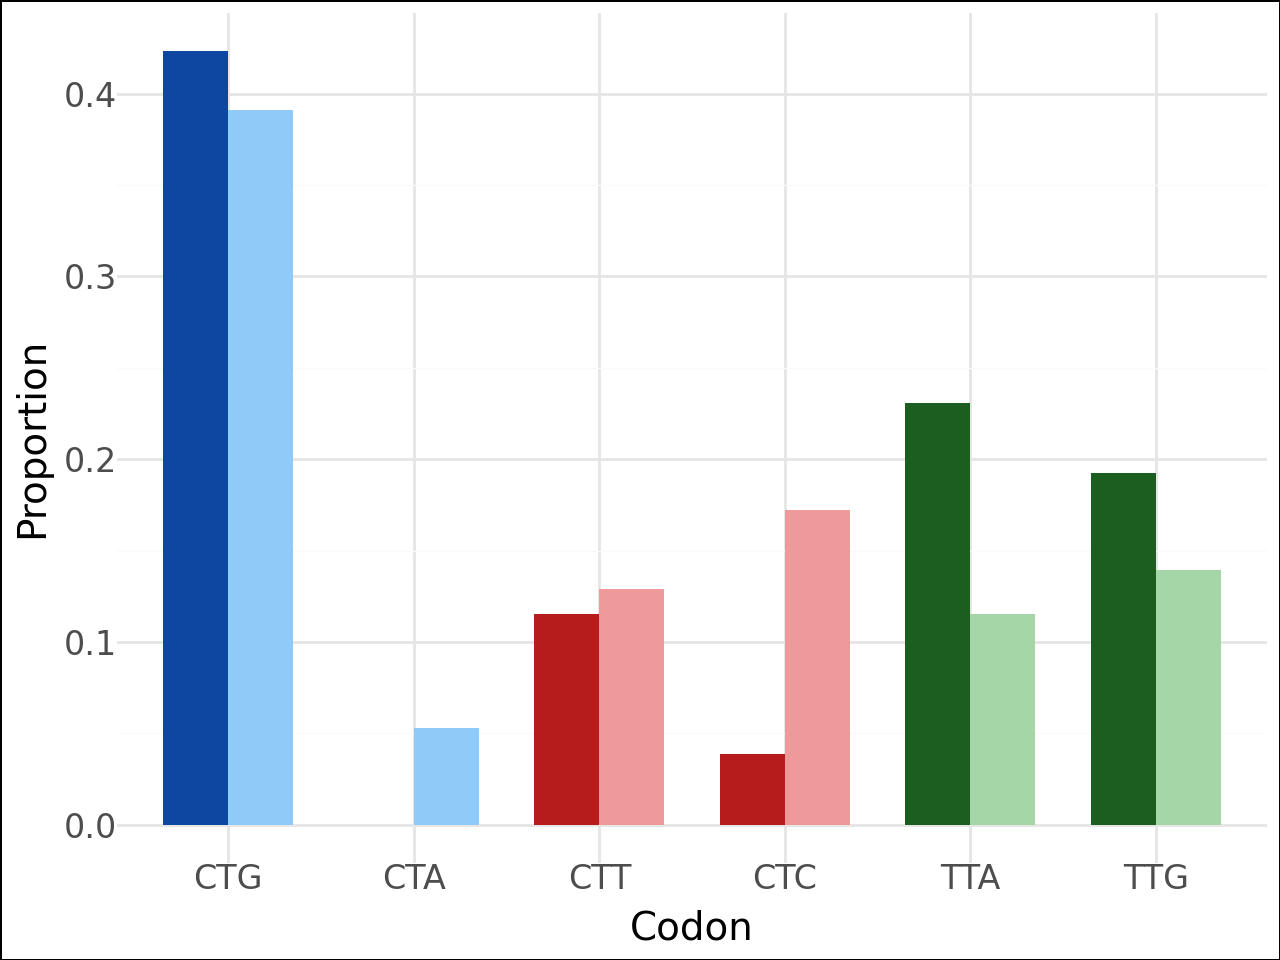

In [22]:
leu_order = ["CTG","CTA","CTT","CTC","TTA","TTG"]
leucine_plot = plot_aa_codons(df, "Leucine", leu_order)
leucine_plot
#leucine_plot.save("leucine_plot.png", width=6, height=4, dpi=300)

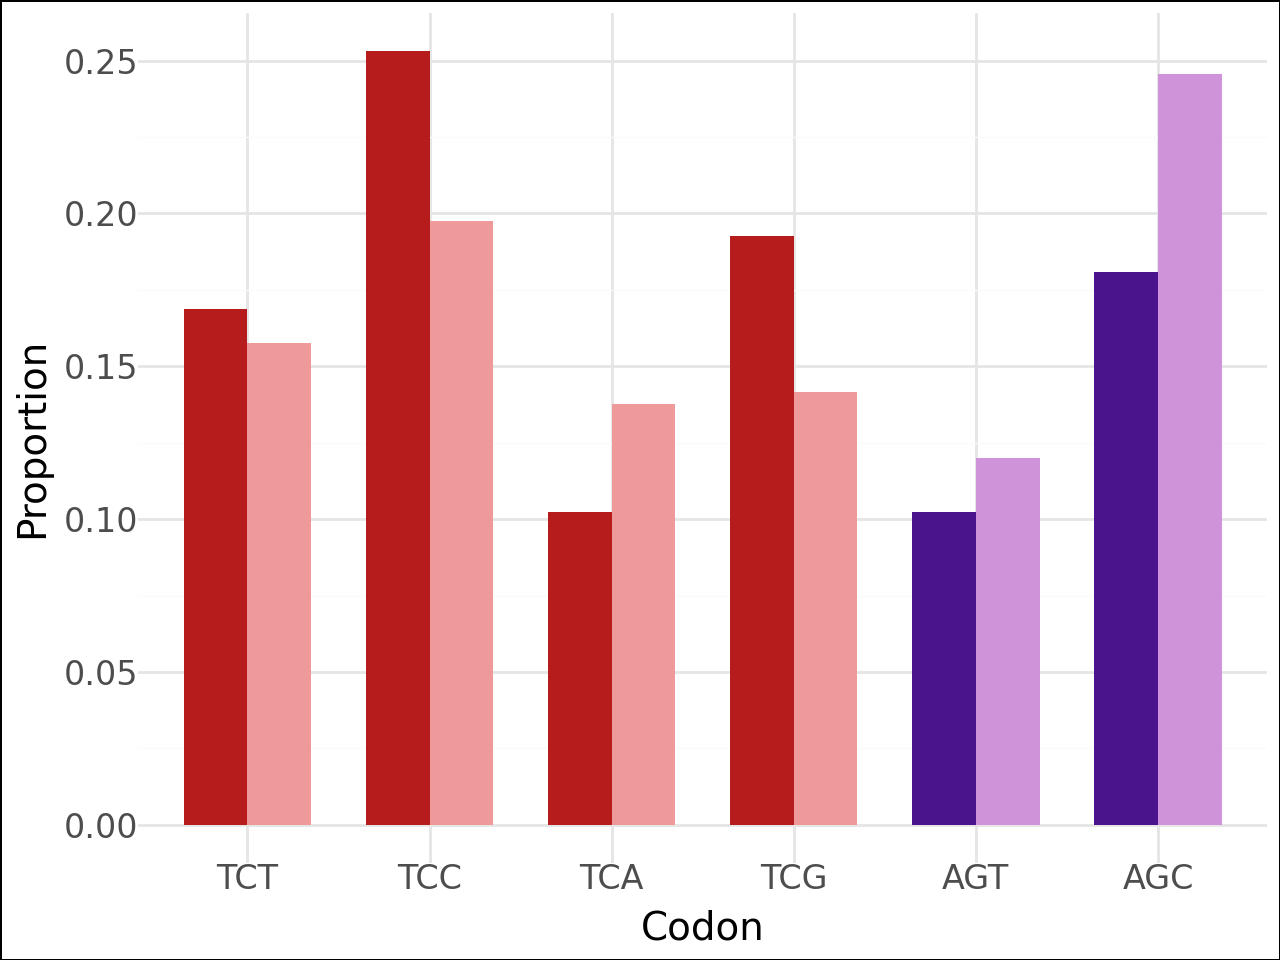

In [23]:
ser_order = ["TCT","TCC","TCA","TCG","AGT","AGC"]
serine_plot = plot_aa_codons(df, "Serine", ser_order)
serine_plot
#serine_plot.save("serine_plot.png", width=6, height=4, dpi=300)

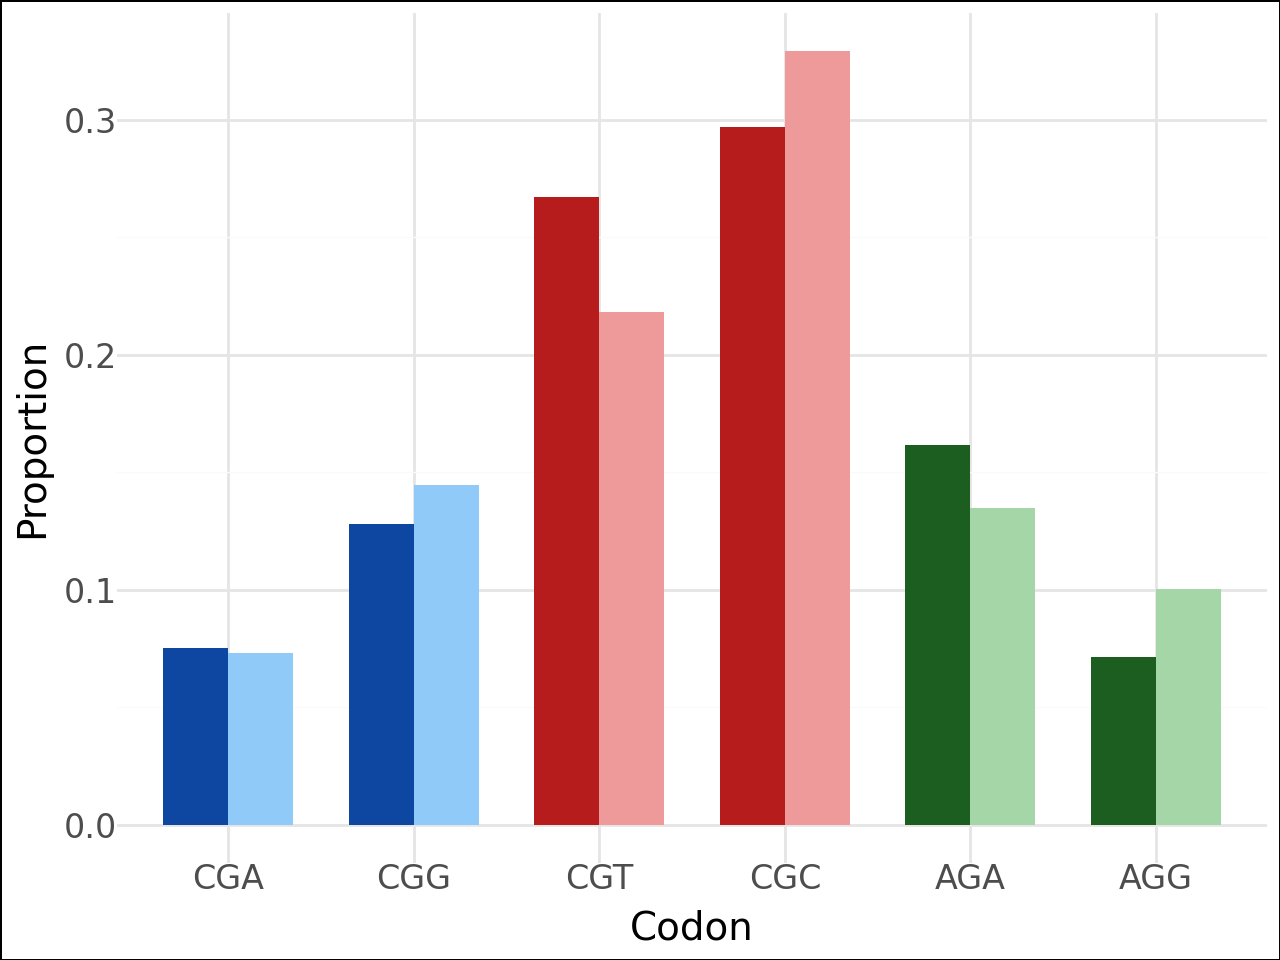

In [24]:
arg_order = ["CGA","CGG", "CGT","CGC","AGA","AGG"]
arginine_plot = plot_aa_codons(df, "Arginine", arg_order)
arginine_plot
#arginine_plot.save("arginine_plot.png", width=6, height=4, dpi=300)

<h1>Chi square test for significance</h1>

Null Hypothesis (H₀):
The codon distribution in binding sites is the same as in non-binding sites (i.e., no selection pressure).

Alternative Hypothesis (H₁):
The codon distribution in binding sites is significantly different from non-binding sites (i.e., possible selection pressure).

In [25]:
codon_subsets = {
    "Arginine": {"CGT", "CGC", "CGA", "CGG", "AGA", "AGG"},
    "Leucine": {'CTG', 'CTA', 'CTT', 'CTC', 'TTA', 'TTG'},
    "Serine": {"TCT", "TCC", "TCA", "TCG", "AGT", "AGC"}
}

In [26]:
results = {}

for aa, codons in codon_subsets.items():
    # build the keys into your nested dict
    bind_key    = f"{aa} Binding Site"
    nonbind_key = f"{aa} Non-binding Site"
    
    # adding plus one as a pseudocount to not get zero values for some codons
    bind_counts    = pd.Series(counts[bind_key]) + 1
    nonbind_counts = pd.Series(counts[nonbind_key]) + 1
    
    # scale the non-binding to the same total as binding
    scale_factor = bind_counts.sum() / nonbind_counts.sum()
    expected     = nonbind_counts * scale_factor
    
    # chi-square test
    chi2_stat, p_value = chisquare(f_obs=bind_counts, f_exp=expected)
    
    results[aa] = {"Chi-squared Statistic": chi2_stat, "P-value": p_value}

    print(f"Results for {aa}:")
    print(f"  Chi-squared Statistic: {chi2_stat:.3f}")
    print(f"  P-value: {p_value:.5f}")
    if p_value < 0.05:
        print("  Significant difference detected (possible selection pressure).")
    else:
        print("  No significant difference detected (no strong selection pressure).")
    print("-" * 50) 

Results for Arginine:
  Chi-squared Statistic: 7.621
  P-value: 0.17841
  No significant difference detected (no strong selection pressure).
--------------------------------------------------
Results for Leucine:
  Chi-squared Statistic: 6.027
  P-value: 0.30358
  No significant difference detected (no strong selection pressure).
--------------------------------------------------
Results for Serine:
  Chi-squared Statistic: 10.316
  P-value: 0.06676
  No significant difference detected (no strong selection pressure).
--------------------------------------------------


<h1>Chi-squared test just for E. Coli</h1>

In [27]:
df_ecoli = df_aligned[df_aligned["organism"] == "Escherichia coli"]
_ ,ecoli_counts = calculate_proportions(df_ecoli)

In [28]:
results = {}

for aa, codons in codon_subsets.items():
    # build the keys into your nested dict
    bind_key = f"{aa} Binding Site"
    nonbind_key = f"{aa} Non-binding Site"
    
    # adding plus one as a pseudocount to not get zero values for some codons
    bind_counts = pd.Series(ecoli_counts[bind_key]) + 1
    nonbind_counts = pd.Series(ecoli_counts[nonbind_key]) + 1
    
    # scale the non-binding to the same total as binding
    expected = bind_counts.sum() * nonbind_counts / nonbind_counts.sum()
    
    # chi-square test
    chi2_stat, p_value = chisquare(f_obs=bind_counts, f_exp=expected)
    
    results[aa] = {"Chi-squared Statistic": chi2_stat, "P-value": p_value}

    print(f"Results for {aa}:")
    print(f"  Chi-squared Statistic: {chi2_stat:.3f}")
    print(f"  P-value: {p_value:.5f}")
    if p_value < 0.05:
        print("  Significant difference detected (possible selection pressure).")
    else:
        print("  No significant difference detected (no strong selection pressure).")
    print("-" * 50) 

Results for Arginine:
  Chi-squared Statistic: 4.320
  P-value: 0.50438
  No significant difference detected (no strong selection pressure).
--------------------------------------------------
Results for Leucine:
  Chi-squared Statistic: 3.759
  P-value: 0.58464
  No significant difference detected (no strong selection pressure).
--------------------------------------------------
Results for Serine:
  Chi-squared Statistic: 2.849
  P-value: 0.72326
  No significant difference detected (no strong selection pressure).
--------------------------------------------------


<h1>Chi-squared test with no E.Coli</h1>

In [29]:
df_without_ecoli = df_aligned[df_aligned["organism"] != "Escherichia coli"]
_ ,no_ecoli_counts = calculate_proportions(df_without_ecoli)

P06968 0 70 Arg CCG
P26440 0 416 Arg GTC
P26440 1 165 Arg CTG


In [30]:
results = {}

for aa, codons in codon_subsets.items():
    # build the keys into your nested dict
    bind_key = f"{aa} Binding Site"
    nonbind_key = f"{aa} Non-binding Site"
    
    # adding plus one as a pseudocount to not get zero values for some codons
    bind_counts = pd.Series(no_ecoli_counts[bind_key]) + 1
    nonbind_counts = pd.Series(no_ecoli_counts[nonbind_key]) + 1
    
    # scale the non-binding to the same total as binding
    expected = bind_counts.sum() * nonbind_counts / nonbind_counts.sum()
    
    # chi-square test
    chi2_stat, p_value = chisquare(f_obs=bind_counts, f_exp=expected)
    
    results[aa] = {"Chi-squared Statistic": chi2_stat, "P-value": p_value}

    print(f"Results for {aa}:")
    print(f"  Chi-squared Statistic: {chi2_stat:.3f}")
    print(f"  P-value: {p_value:.5f}")
    if p_value < 0.05:
        print("  Significant difference detected (possible selection pressure).")
    else:
        print("  No significant difference detected (no strong selection pressure).")
    print("-" * 50) 

Results for Arginine:
  Chi-squared Statistic: 9.116
  P-value: 0.10454
  No significant difference detected (no strong selection pressure).
--------------------------------------------------
Results for Leucine:
  Chi-squared Statistic: 6.298
  P-value: 0.27833
  No significant difference detected (no strong selection pressure).
--------------------------------------------------
Results for Serine:
  Chi-squared Statistic: 10.195
  P-value: 0.06988
  No significant difference detected (no strong selection pressure).
--------------------------------------------------
